# Configuration

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Anime Recommendations") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

25/04/23 11:15:50 WARN Utils: Your hostname, p4stwi2x resolves to a loopback address: 127.0.1.1; using 192.168.100.188 instead (on interface wlp2s0)
25/04/23 11:15:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/23 11:15:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# ALS model

## Model

Dataset splitting

In [ ]:
# Split into train, test and validation set (70-5-25 split)
train_df, val_df, test_df = df.randomSplit([0.7, 0.05, 0.25], seed=42)

Verifying if the splits still represent the original data well and aren't biased or skewed toward certain users, items, or rating values.

In [ ]:
print(f"Train count: {train_df.count()}")
print(f"Validation count: {val_df.count()}")
print(f"Test count: {test_df.count()}")

Checking the distribution of ratings if theythey have similar distributions across the splits.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

train_ratings = train_df.select('rating').toPandas()
val_ratings = val_df.select('rating').toPandas()
test_ratings = test_df.select('rating').toPandas()

plt.figure(figsize=(15, 5))

sns.kdeplot(train_ratings['rating'], label='Train', fill=True)
sns.kdeplot(val_ratings['rating'], label='Validation', fill=True)
sns.kdeplot(test_ratings['rating'], label='Test', fill=True)

plt.title('Rating Distribution Across Splits')
plt.legend()
plt.show()

Model configuration and training

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

# Then train ALS directly on the DataFrames
als = ALS(
    maxIter=10,
    regParam=0.1,
    userCol="user_id",
    itemCol="anime_id",
    ratingCol="rating",
    coldStartStrategy="drop",
    nonnegative=True
)

# Train on training set
model = als.fit(train_df)

# Validate on validation set
val_predictions = model.transform(val_df)

Training evaluation

In [ ]:
# Evaluate using RMSE
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)
val_rmse = evaluator.evaluate(val_predictions)
print(f"Validation RMSE: {val_rmse}")

# Final evaluation on test set (after model selection if you're tuning)
test_predictions = model.transform(test_df)
test_rmse = evaluator.evaluate(test_predictions)
print(f"Test RMSE: {test_rmse}")

Validation RMSE: 1.2579283213397923
Test RMSE: 1.2595530214574195


Model saving

In [ ]:
# Save the ALS model
model_path = "/content/als_model"  # Replace with your desired path
model.save(model_path)

print(f"ALS model saved to: {model_path}")

ALS model saved to: /content/als_model


## Deploy

### Configurations

In [ ]:
import random
def generateNewID(dataFrame):
    existing_id_list = dataFrame.select("user_id").distinct().rdd.map(lambda x: x[0]).collect()
    mx = max(existing_id_list)
    a = existing_id_list[0]
    while a in existing_id_list:
        a = random.randint(1, mx*2)
    return a

In [ ]:
from pyspark.sql.functions import lit
from pyspark.ml.recommendation import ALSModel
from pyspark.sql.types import StructType, StructField, IntegerType
dataset_dir = "../../dataset/"
anime_dataset_path = dataset_dir + "anime-dataset-2023.csv"
user_input_path = "myRating.csv"
model_dir = "../als_model"

anime_df = spark.read.csv(anime_dataset_path, header=True) \
    .select("anime_id", "Name", "Genres", "Synopsis")
user_input_df = spark.read.csv(user_input_path, header=True, schema=StructType([\
        StructField("anime_id", IntegerType(), True),\
        StructField("rating", IntegerType(), True)\
    ]))\
    .withColumn("user_id", lit(generateNewID()))\

model = ALSModel.load(model_dir)

### Recommendation

In [ ]:
# Generate recommendations for all users
recommendations = model.transform(user_input_df)

In [ ]:
from pyspark.sql.functions import col

# Animes user has already watched
watched = user_input_df.select("anime_id").rdd.map(lambda x: x[0]).collect()

# Join recommendations with anime details
recommendations_with_details = recommendations \
    .join(anime_df, recommendations.anime_id == anime_df.anime_id, 'left') \
    .select(
        anime_df["anime_id"],
        "Name",
        "Genres",
        "Synopsis",
        "prediction"
    )\
    .filter(~col("anime_id").isin(watched))

In [ ]:
from pyspark.sql.functions import col
# Sort recommendations by prediction score
final_recommendations = recommendations_with_details \
    .orderBy(col("prediction").desc())

In [ ]:
# Show top recommendations
final_recommendations.show()

+--------+----+------+--------+----------+
|anime_id|Name|Genres|Synopsis|prediction|
+--------+----+------+--------+----------+
+--------+----+------+--------+----------+



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud

In [ ]:
recommendations_pd = final_recommendations.limit(50).toPandas()

In [ ]:
recommendations_pd.head()

,user_id,Name,Genres,Synopsis,prediction
0,1243251,Koyoi wa Halloween Night!,Supernatural,Official music video for original song by Rush...,13.272511
1,834209,Puzzle & Dragon,UNKNOWN,The story is set in modern day Japan following...,12.783225
2,35909,Pure-tou no Nakama-tachi,Fantasy,Kona is a boy who has a friend: a pink dragon ...,12.731651
3,443923,School Days,"Drama, Romance",High school student Makoto Itou first notices ...,12.601631
4,106350,Kouchuu Ouja Mushiking Super Battle Movie: Yam...,"Adventure, Fantasy",A shadow of Darkness approaches a peaceful For...,12.557821


In [ ]:
# Convert to Pandas DataFrame for visualization
def visualize_user_recommendations(user_id):
    user_recs = recommendations_pd[recommendations_pd['user_id'] == user_id].head(10)

    # Create figure
    plt.figure(figsize=(15, 10))

    # Top recommended anime
    plt.subplot(2, 2, 1)
    sns.barplot(x='prediction', y='Name', data=user_recs)
    plt.title(f'Top Recommendations for User {user_id}')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Anime Title')

    # Genre distribution
    plt.subplot(2, 2, 2)
    genres = user_recs['Genres'].str.split(',', expand=True).stack()
    genres.value_counts().head(10).plot(kind='bar')
    plt.title('Recommended Genre Distribution')
    plt.xticks(rotation=45)

    # Rating distribution
    plt.subplot(2, 2, 3)
    sns.histplot(user_recs['prediction'], bins=10, kde=True)
    plt.title('Predicted Rating Distribution')
    plt.xlabel('Predicted Rating')

    # Word cloud of synopsis (requires wordcloud package)
    plt.subplot(2, 2, 4)
    text = ' '.join(user_recs['Synopsis'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Common Themes in Recommendations')

    plt.tight_layout()
    plt.show()

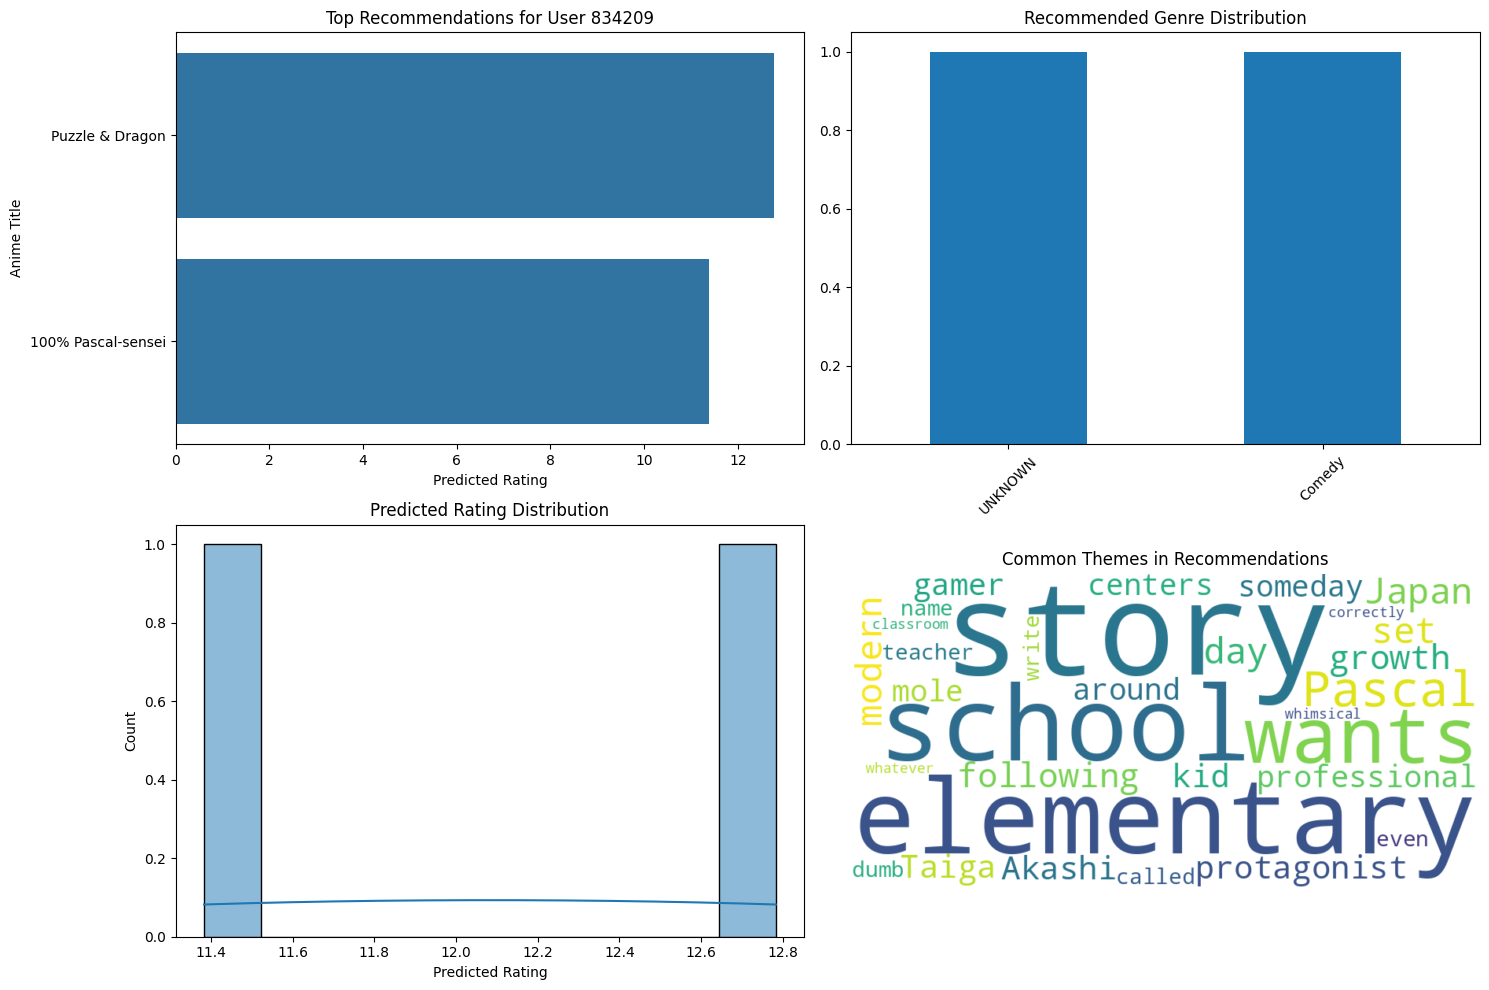

In [ ]:
# Example usage
visualize_user_recommendations(user_id=834209)  # replace with actual user ID

In [ ]:
final_recommendations.show()

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
def visualize_recommendation_distribution():
    # Get prediction distribution
    pred_dist = final_recommendations.select("prediction").toPandas()

    # Create a histogram of the predictions
    plt.figure(figsize=(10, 6))
    sns.histplot(pred_dist['prediction'], bins=20, kde=True)
    plt.title('Distribution of Predicted Ratings')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Count')
    plt.show()

In [ ]:
visualize_recommendation_distribution()

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
import networkx as nx

def visualize_anime_network(user_id, top_n=15):
    user_recs = final_recommendations.filter(col("user_id") == user_id) \
                                    .limit(top_n).toPandas()

    G = nx.Graph()

    # Add nodes (anime)
    for _, row in user_recs.iterrows():
        G.add_node(row['anime_name'],
                  genres=row['Genres'],
                  rating=row['prediction'])

    # Add edges based on shared genres
    for i, row1 in user_recs.iterrows():
        genres1 = set(row1['Genres'].split(','))
        for j, row2 in user_recs.iterrows():
            if i >= j:
                continue
            genres2 = set(row2['Genres'].split(','))
            shared = genres1.intersection(genres2)
            if shared:
                G.add_edge(row1['anime_name'], row2['anime_name'],
                          weight=len(shared),
                          genres=",".join(shared))

    # Draw the graph
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G)

    # Node size by predicted rating
    node_sizes = [G.nodes[n]['rating']*100 for n in G.nodes()]

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes,
                          node_color='lightblue', alpha=0.9)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10)

    plt.title(f'Anime Recommendation Network for User {user_id}')
    plt.axis('off')
    plt.show()

# Example usage
visualize_anime_network(user_id=834209)

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
from google.colab import files
import os
import shutil
import zipfile

# Specify the directory to download
download_dir = "/content/als_model"

# Check if the directory exists
if os.path.exists(download_dir):
  # Create a temporary zip file
  zip_filename = "als_model_download.zip"

  # Create a zip file with the entire directory structure
  with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through the directory
    for root, dirs, files in os.walk(download_dir):
      for file in files:
        # Calculate path for file in zip
        file_path = os.path.join(root, file)
        # Calculate the relative path to maintain folder structure
        rel_path = os.path.relpath(file_path, os.path.dirname(download_dir))
        zipf.write(file_path, rel_path)

  # Download the zip file
  files.download(zip_filename)
  print(f"All files and folders from '{download_dir}' have been downloaded as '{zip_filename}'.")
else:
  print(f"Error: The directory '{download_dir}' does not exist.")

AttributeError: 'list' object has no attribute 'download'

In [ ]:
import tensorflow as tf

## Import necessary modules for collaborative filtering
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

tf_version = tf.__version__
print(f"TensorFlow version: {tf_version}")

TensorFlow version: 2.18.0


In [ ]:
import numpy as np

def prepare_spark_data(df):
    # Collect data as separate arrays
    user_data = np.array(df.select("user_encoded").rdd.flatMap(lambda x: x).collect(), dtype=np.int64)
    anime_data = np.array(df.select("anime_encoded").rdd.flatMap(lambda x: x).collect(), dtype=np.int64)
    ratings = np.array(df.select("scaled_rating").rdd.flatMap(lambda x: x).collect(), dtype=np.float32)

    return [user_data, anime_data], ratings

# Prepare data
X_train, y_train = prepare_spark_data(train_df)
X_test, y_test = prepare_spark_data(test_df)

In [ ]:
from wordcloud import WordCloud
from collections import defaultdict
from collections import Counter

In [ ]:
def RecommenderNet(num_users, num_animes, embedding_size=128):
    # User input layer and embedding layer
    user = Input(name='user_encoded', shape=[1])
    user_embedding = Embedding(name='user_embedding', input_dim=num_users, output_dim=embedding_size)(user)

    # Anime input layer and embedding layer
    anime = Input(name='anime_encoded', shape=[1])
    anime_embedding = Embedding(name='anime_embedding', input_dim=num_animes, output_dim=embedding_size)(anime)

    # Dot product of user and anime embeddings
    dot_product = Dot(name='dot_product', normalize=True, axes=2)([user_embedding, anime_embedding])
    flattened = Flatten()(dot_product)

    # Dense layers for prediction
    dense = Dense(64, activation='relu')(flattened)
    output = Dense(1, activation='sigmoid')(dense)

    # Create and compile the model
    model = Model(inputs=[user, anime], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=["mae", "mse"])

    return model

print(num_users)
print(num_animes)
model = RecommenderNet(num_users, num_animes)

# Printing my model summary
model.summary()

74
2603


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_encoded (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ anime_encoded             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 128)         │          9,472 │ user_encoded[0][0]     │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ anime_embedding           │ (None, 1, 128)         │        333,184 │ anime_encoded[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_product (Dot)         │ (None, 1, 1)           │              0 │ user_embedding[0][0],  │
│                           │                        │                │ anime_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1)              │              0 │ dot_product[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │            128 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             65 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 342,849 (1.31 MB)

 Trainable params: 342,849 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

# Define the initial learning rate, minimum learning rate, maximum learning rate, and batch size
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 1000

# Define the number of epochs for ramp-up, sustain, and exponential decay
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

In [ ]:
# Learning rate schedule function
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

# Learning rate scheduler callback
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

# File path for saving the model weights
checkpoint_filepath = '/content/myanime.weights.h5'

# Model checkpoint callback to save the best weights
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Define the list of callbacks
my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping
]

In [ ]:
# Model training
tf.config.run_functions_eagerly(True)

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - loss: 0.6899 - mae: 0.2499 - mse: 0.0823 - val_loss: 0.6905 - val_mae: 0.2481 - val_mse: 0.0814 - learning_rate: 1.0000e-05
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.6897 - mae: 0.2504 - mse: 0.0823 - val_loss: 0.6903 - val_mae: 0.2479 - val_mse: 0.0813 - learning_rate: 1.8000e-05
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.6895 - mae: 0.2494 - mse: 0.0820 - val_loss: 0.6900 - val_mae: 0.2477 - val_mse: 0.0812 - learning_rate: 2.6000e-05
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 0.6890 - mae: 0.2503 - mse: 0.0824 - val_loss: 0.6896 - val_mae: 0.2473 - val_mse: 0.0810 - learning_rate: 3.4000e-05
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.6884 - mae: 0.2499 - mse: 0.0821 - val_loss: 0.6890 - val_mae: 0.2468 - val_mse: 0.0807 - learning_rate: 4.2000e-05
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.6878 - mae: 0.2486 - mse: 0.0816 - val_loss: 0.6884 - val_mae

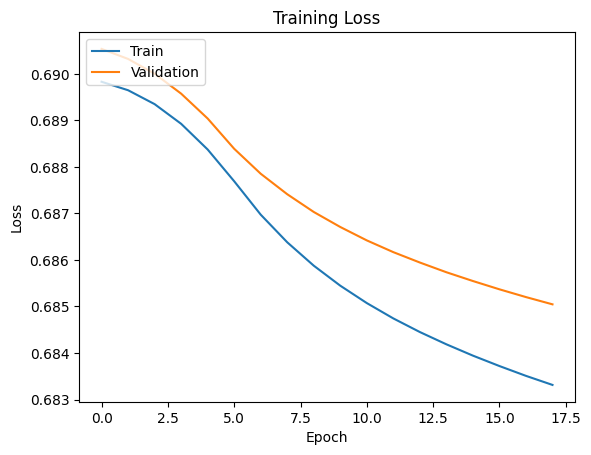

In [ ]:
# Training results visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()